In [1]:
import os
from PIL import Image
import torch
from torch import nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.transforms.functional import to_tensor, to_pil_image
from IPython.display import display

from clip.simple_tokenizer import SimpleTokenizer
from utils.initialize_font_data import font_dir, fox_text_four_lines, train_json_path, exclusive_attributes, gray_scale_image_file_dir
from utils.init_model import model, preprocess, my_preprocess, device, convert_weights, model_name, _download, _MODELS, load
from dataset.dataset import MyDataset, set_image_tensors
from models.lora_clip import LoRACLIP

tokenizer = SimpleTokenizer()

exclusive_attributes:  []
loading JIT archive /home/yuki/.cache/clip/ViT-B-32.pt


In [2]:
dataset = MyDataset(
  font_dir, 
  train_json_path, 
  [fox_text_four_lines], 
  char_size=150,
  attribute_threshold=50,
  use_negative=True,
  preprocess=my_preprocess, 
  use_multiple_attributes=True, 
  use_random_attributes=True, 
  max_sample_num=3, 
  random_prompts_num=10,
  exclusive_attributes=exclusive_attributes,
  image_file_dir=gray_scale_image_file_dir,
  dump_image=True,
)
set_image_tensors(dataset, sample_num=5)
data_loader = DataLoader(dataset, batch_size=4, shuffle=False)

  0%|          | 0/120 [00:00<?, ?it/s]

100%|██████████| 120/120 [00:00<00:00, 857.99it/s]


load image tensors from image files ...


100%|██████████| 120/120 [00:00<00:00, 244.96it/s]


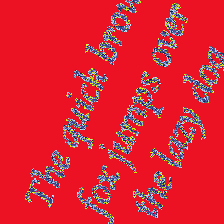

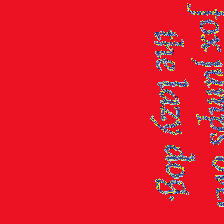

<|startoftext|>soft font <|endoftext|>!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


In [3]:
for batch in iter(data_loader):
  images, texts = batch
  int_text = [int(token) for token in texts[0]]
  decoded_text = tokenizer.decode(int_text)
  display(to_pil_image(images[0]))
  display(to_pil_image(images[1]))
  print(decoded_text)
  break

In [4]:
embed_dim = 512
image_resolution = 224
vision_layers = 12
vision_width = 768
vision_patch_size = 32
context_length = 77
vocab_size = 49408
transformer_width = 512
transformer_heads = 8
transformer_layers = 12
lora_r = 16
lora_alpha = 16.0

In [5]:
lora_model = LoRACLIP(
  embed_dim,
  image_resolution,
  vision_layers,
  vision_width,
  vision_patch_size,
  context_length,
  vocab_size,
  transformer_width,
  transformer_heads,
  transformer_layers,
  lora_r=lora_r,
  lora_alpha=lora_alpha,
).to(device)
# load pretrained CLIP model
lora_model.load_state_dict(model.state_dict(), strict=False)
# check if lora_model.transformer.resblocks[0].attn.q_lora_proj_weight_b is zeros
print(lora_model.transformer.resblocks[0].attn.q_lora_proj_weight_b.shape)
print(lora_model.transformer.resblocks[0].attn.q_lora_proj_weight_a.shape)
assert torch.all(lora_model.transformer.resblocks[0].attn.q_lora_proj_weight_b == 0)
assert torch.all(lora_model.transformer.resblocks[0].attn.v_lora_proj_weight_b == 0)

convert_weights(lora_model)
assert lora_model.transformer.resblocks[0].attn.q_lora_proj_weight_b.dtype == torch.float16

'Transformer' object has no attribute 'initialize_lora_parameters'
torch.Size([16, 512])
torch.Size([512, 16])


In [6]:
images, texts = next(iter(data_loader))
images = images.to(device)
texts = texts.to(device)

In [7]:
image_features = lora_model.encode_image(images)
text_features = lora_model.encode_text(texts)

In [8]:
for name, param in lora_model.named_parameters():
    if "lora_proj_weight" in name:
        param.requires_grad = True
    else:
        param.requires_grad = False

lora_optimizer = optim.Adam(
    lora_model.lora_parameters(),
    lr=1e-3,
    betas=(0.9, 0.98),
    eps=1e-6,
    weight_decay=0.2,
)

In [10]:
lora_model.train()
lora_optimizer.zero_grad()
images, texts = next(iter(data_loader))
print(images.dtype)
images = images.to(device)
texts = texts.to(device)

# input
# image_features = lora_model.encode_image(images)
# text_features = lora_model.encode_text(texts)
# image_features = image_features / image_features.norm(
#     dim=-1, keepdim=True
# )
# text_features = text_features / text_features.norm(
#     dim=-1, keepdim=True
# )
# logit_scale = lora_model.logit_scale.exp()
# logits_per_image = (
#     logit_scale * image_features @ text_features.t()
# )
# logits_per_text = logits_per_image.t()
logits_per_image, logits_per_text = lora_model(
    images, texts
)
ground_truth = torch.arange(
    len(images), dtype=torch.long, device=device
)
loss_img = nn.CrossEntropyLoss()
loss_txt = nn.CrossEntropyLoss()
total_loss = (
    loss_img(logits_per_image, ground_truth)
    + loss_txt(logits_per_text, ground_truth)
) / 2
total_loss.backward()
lora_optimizer.step()
print(lora_model.transformer.resblocks[1].mlp.c_fc.weight[0][0])
print(lora_model.visual.transformer.resblocks[1].mlp.c_fc.weight[0][0])
print(lora_model.transformer.resblocks[0].attn.q_lora_proj_weight_b[0][0])
print(lora_model.transformer.resblocks[0].attn.q_lora_proj_weight_a[0][0])
# print(lora_model.transformer.resblocks[0].attn.v_lora_proj_weight_b)
# print(lora_model.transformer.resblocks[0].attn.q_lora_proj_weight_a)
# print(lora_model.transformer.resblocks[0].attn.v_lora_proj_weight_a)

torch.float16
tensor(-0.0153, device='cuda:0', dtype=torch.float16)
tensor(0.0029, device='cuda:0', dtype=torch.float16)
tensor(0.0003, device='cuda:0', dtype=torch.float16, grad_fn=<SelectBackward0>)
tensor(0.0051, device='cuda:0', dtype=torch.float16, grad_fn=<SelectBackward0>)


In [10]:
aaa

NameError: name 'aaa' is not defined

# Evaluate LoRA with CIFAR100

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
import tqdm
import torch
from torchvision.datasets import CIFAR100

import clip

In [ ]:
cifar100 = CIFAR100(os.path.expanduser("~/.cache"), transform=preprocess, download=True, train=False)
print(len(cifar100))

Files already downloaded and verified
10000


In [ ]:
norm = preprocess.transforms[-1]
def denormalize(img):
  return img * torch.tensor(norm.std)[:, None, None] + torch.tensor(norm.mean)[:, None, None]
norm.mean, norm.std

((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711))

(torch.Size([224, 224, 3]), tensor(0.1765), tensor(1.))

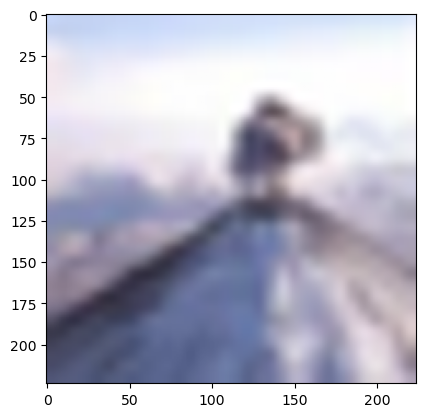

In [ ]:
img, label = next(iter(cifar100))
img = denormalize(img).permute(1, 2, 0)
plt.imshow(img)
img.shape, img.min(), img.max()

In [ ]:
batch_size = 128
data_loader = torch.utils.data.DataLoader(cifar100,
                                          batch_size=batch_size,
                                          shuffle=False)

## Show some examples

In [ ]:
image_input, image_labels = next(iter(data_loader))
image_input = image_input.cuda()
text_descriptions = [f"This is a photo of a {label}" for label in cifar100.classes]
text_tokens = clip.tokenize(text_descriptions).cuda()
with torch.no_grad():
  image_features = lora_model.encode_image(image_input).float()
  image_features /= image_features.norm(dim=-1, keepdim=True)
  text_features = lora_model.encode_text(text_tokens).float()
  text_features /= text_features.norm(dim=-1, keepdim=True)
print(image_features.shape, text_features.shape)
text_probs = (100.0 * image_features @ text_features.T).softmax(dim=-1)
top_probs, top_labels = text_probs.cpu().topk(5, dim=-1)

LoRATransformer forward
LoRATransformer forward
torch.Size([128, 512]) torch.Size([100, 512])


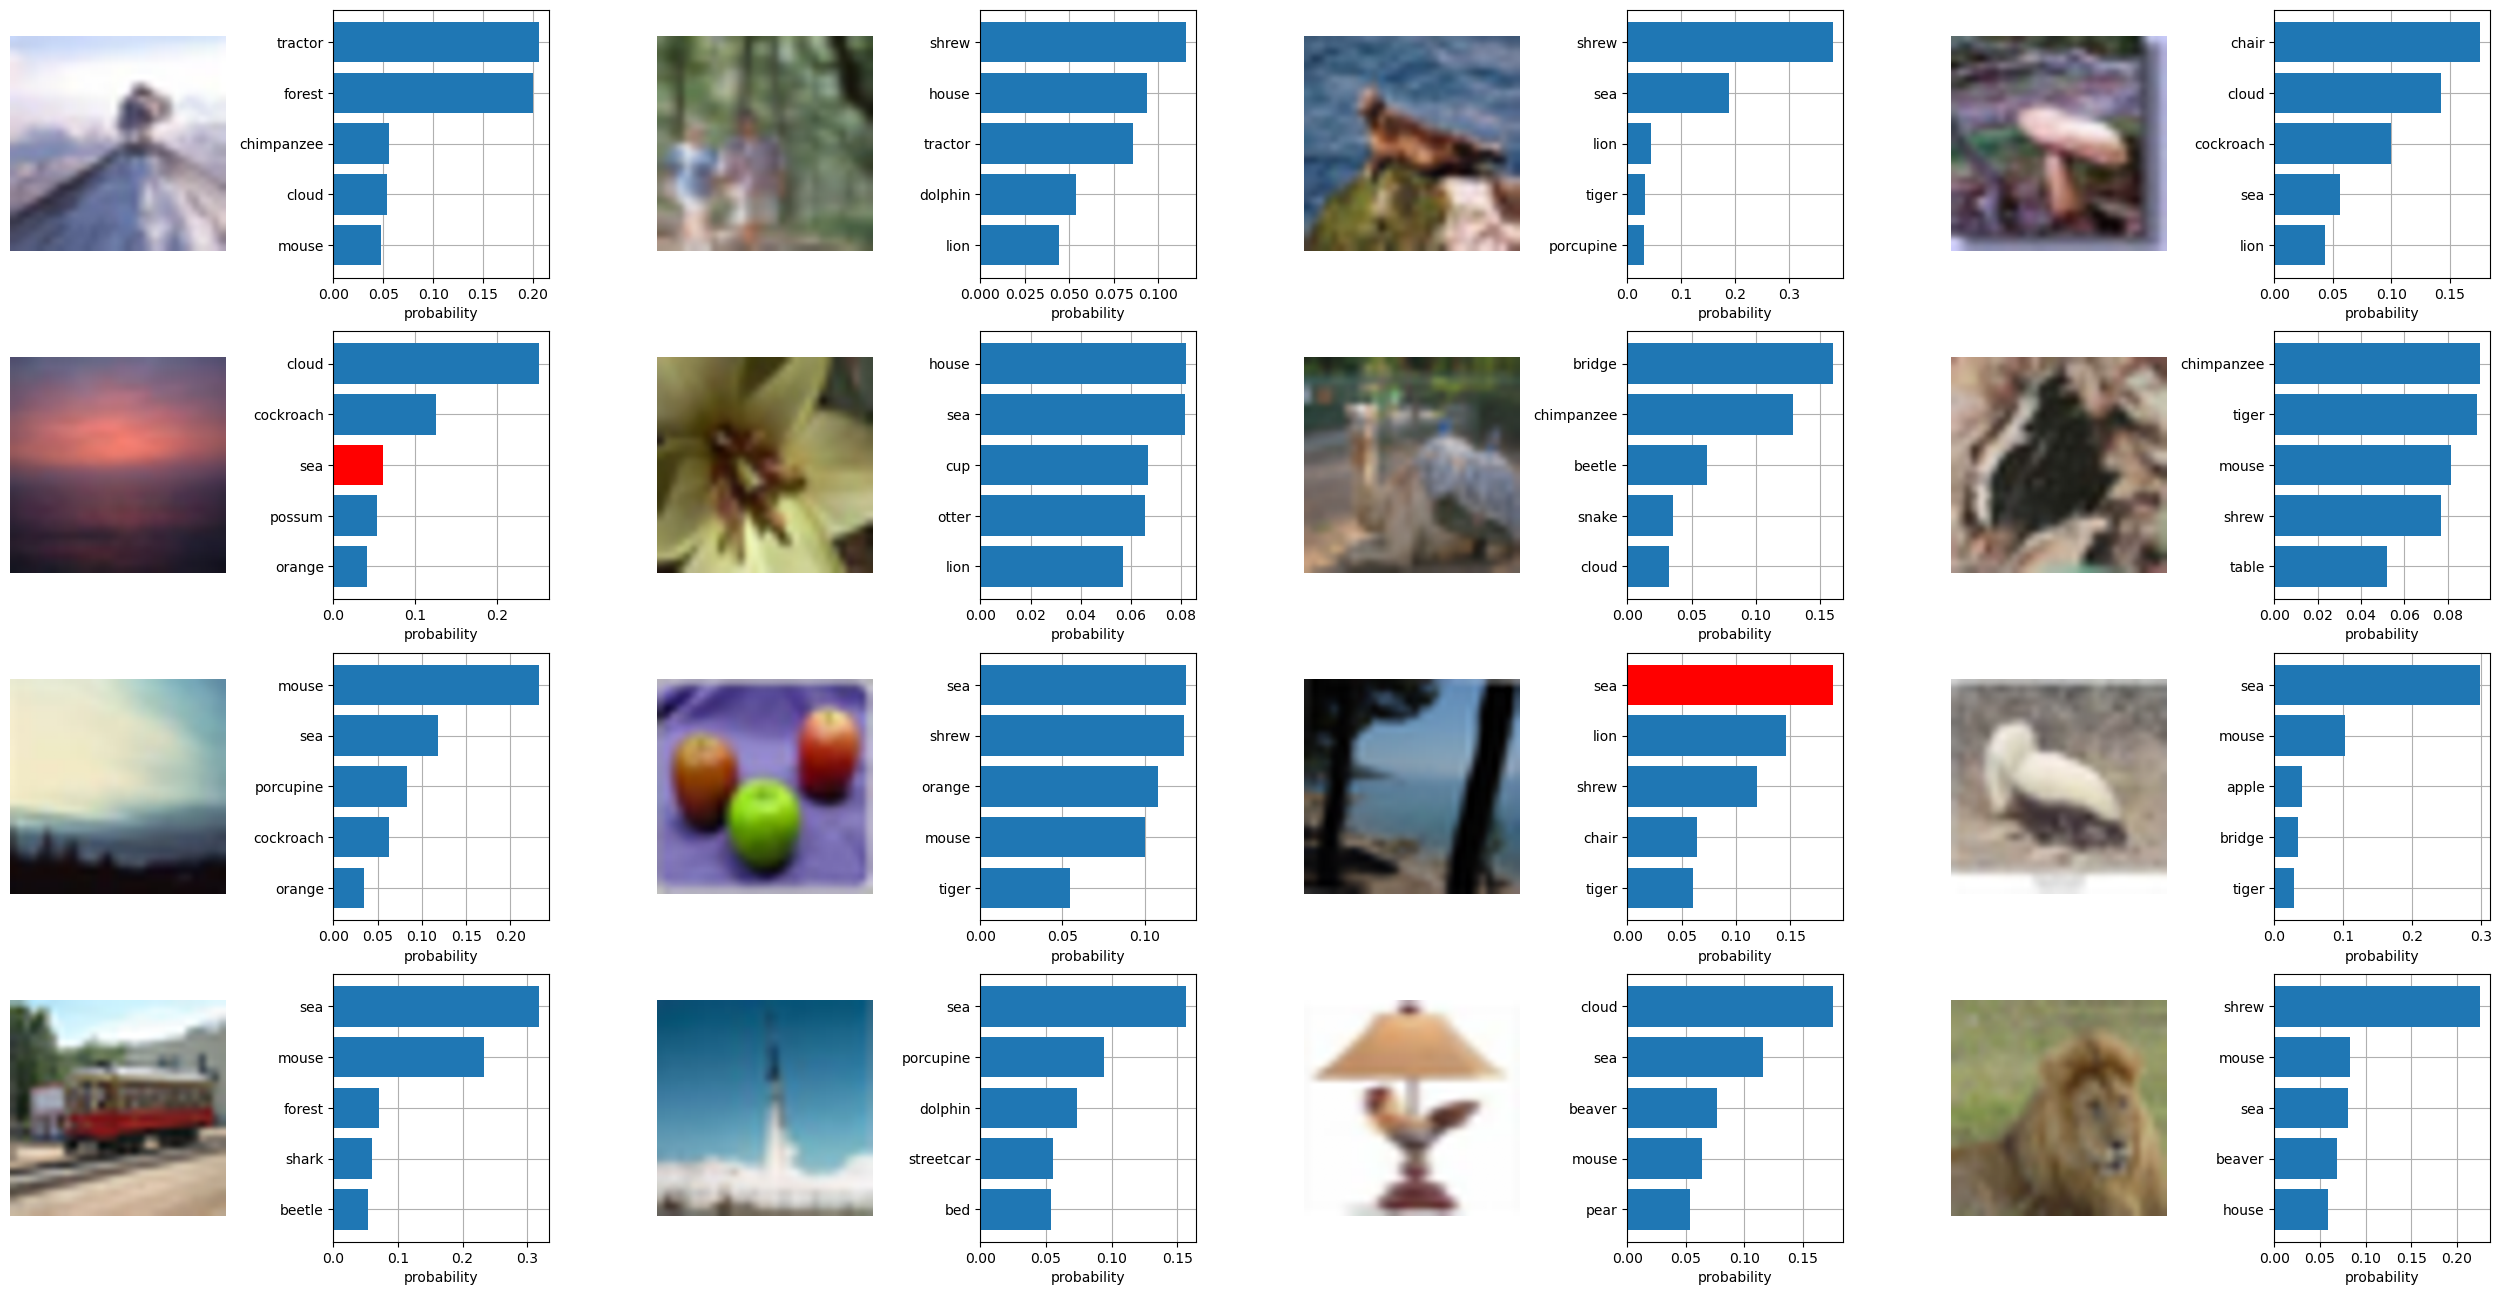

In [ ]:
rows, cols = 4, 4
plt.figure(figsize=(cols*8, rows*4))

for i, image in enumerate(image_input[:rows*cols]):
    plt.subplot(rows, cols * 2, 2 * i + 1)
    plt.imshow(denormalize(image.cpu()).permute(1, 2, 0))
    plt.axis("off")

    plt.subplot(rows, cols * 2, 2 * i + 2)
    y = np.arange(top_probs.shape[-1])
    plt.grid()
    plt.barh(y, top_probs[i])
    plt.gca().invert_yaxis()
    plt.gca().set_axisbelow(True)
    plt.yticks(y, [cifar100.classes[index] for index in top_labels[i].numpy()])
    if image_labels[i] in top_labels[i]:
      j = list(top_labels[i]).index(image_labels[i])
      plt.barh([j], [top_probs[i][j]], color='r')
    plt.xlabel("probability")

plt.subplots_adjust(wspace=0.5)
plt.savefig('outputs/cifar100_CLIPvision_FontCLIPtext.png')
plt.show()

## Quantitative Evaluation with CIFAR100

In [ ]:
templates80 = [
    'a bad photo of a {}.',
    'a photo of many {}.',
    'a sculpture of a {}.',
    'a photo of the hard to see {}.',
    'a low resolution photo of the {}.',
    'a rendering of a {}.',
    'graffiti of a {}.',
    'a bad photo of the {}.',
    'a cropped photo of the {}.',
    'a tattoo of a {}.',
    'the embroidered {}.',
    'a photo of a hard to see {}.',
    'a bright photo of a {}.',
    'a photo of a clean {}.',
    'a photo of a dirty {}.',
    'a dark photo of the {}.',
    'a drawing of a {}.',
    'a photo of my {}.',
    'the plastic {}.',
    'a photo of the cool {}.',
    'a close-up photo of a {}.',
    'a black and white photo of the {}.',
    'a painting of the {}.',
    'a painting of a {}.',
    'a pixelated photo of the {}.',
    'a sculpture of the {}.',
    'a bright photo of the {}.',
    'a cropped photo of a {}.',
    'a plastic {}.',
    'a photo of the dirty {}.',
    'a jpeg corrupted photo of a {}.',
    'a blurry photo of the {}.',
    'a photo of the {}.',
    'a good photo of the {}.',
    'a rendering of the {}.',
    'a {} in a video game.',
    'a photo of one {}.',
    'a doodle of a {}.',
    'a close-up photo of the {}.',
    'a photo of a {}.',
    'the origami {}.',
    'the {} in a video game.',
    'a sketch of a {}.',
    'a doodle of the {}.',
    'a origami {}.',
    'a low resolution photo of a {}.',
    'the toy {}.',
    'a rendition of the {}.',
    'a photo of the clean {}.',
    'a photo of a large {}.',
    'a rendition of a {}.',
    'a photo of a nice {}.',
    'a photo of a weird {}.',
    'a blurry photo of a {}.',
    'a cartoon {}.',
    'art of a {}.',
    'a sketch of the {}.',
    'a embroidered {}.',
    'a pixelated photo of a {}.',
    'itap of the {}.',
    'a jpeg corrupted photo of the {}.',
    'a good photo of a {}.',
    'a plushie {}.',
    'a photo of the nice {}.',
    'a photo of the small {}.',
    'a photo of the weird {}.',
    'the cartoon {}.',
    'art of the {}.',
    'a drawing of the {}.',
    'a photo of the large {}.',
    'a black and white photo of a {}.',
    'the plushie {}.',
    'a dark photo of a {}.',
    'itap of a {}.',
    'graffiti of the {}.',
    'a toy {}.',
    'itap of my {}.',
    'a photo of a cool {}.',
    'a photo of a small {}.',
    'a tattoo of the {}.',
]
templates7 = '''itap of a {}.
a bad photo of the {}.
a origami {}.
a photo of the large {}.
a {} in a video game.
art of the {}.
a photo of the small {}.'''.split('\n')

In [ ]:
def zeroshot_classifier(classnames, templates):
  with torch.no_grad():
    zeroshot_weights = []
    for classname in tqdm.tqdm(classnames):
      texts = [template.format(classname) for template in templates] #format with class
      texts = clip.tokenize(texts).cuda() #tokenize
      class_embeddings = lora_model.encode_text(texts) #embed with text encoder
      class_embeddings /= class_embeddings.norm(dim=-1, keepdim=True)
      class_embedding = class_embeddings.mean(dim=0)
      class_embedding /= class_embedding.norm()
      zeroshot_weights.append(class_embedding)
    zeroshot_weights = torch.stack(zeroshot_weights, dim=1).cuda()
  return zeroshot_weights


zeroshot_weights = zeroshot_classifier(cifar100.classes, templates7)
zeroshot_weights_ = zeroshot_classifier(cifar100.classes, templates80)
print(zeroshot_weights.shape, zeroshot_weights_.shape)

 26%|██▌       | 26/100 [00:00<00:00, 259.30it/s]

LoRATransformer forward
LoRATransformer forward
LoRATransformer forward
LoRATransformer forward
LoRATransformer forward
LoRATransformer forward
LoRATransformer forward
LoRATransformer forward
LoRATransformer forward
LoRATransformer forward
LoRATransformer forward
LoRATransformer forward
LoRATransformer forward
LoRATransformer forward
LoRATransformer forward
LoRATransformer forward
LoRATransformer forward
LoRATransformer forward
LoRATransformer forward
LoRATransformer forward
LoRATransformer forward
LoRATransformer forward
LoRATransformer forward
LoRATransformer forward
LoRATransformer forward
LoRATransformer forward
LoRATransformer forward
LoRATransformer forward
LoRATransformer forward
LoRATransformer forward
LoRATransformer forward
LoRATransformer forward
LoRATransformer forward
LoRATransformer forward
LoRATransformer forward
LoRATransformer forward
LoRATransformer forward
LoRATransformer forward
LoRATransformer forward
LoRATransformer forward
LoRATransformer forward
LoRATransformer 

100%|██████████| 100/100 [00:00<00:00, 266.13it/s]


LoRATransformer forward
LoRATransformer forward
LoRATransformer forward
LoRATransformer forward
LoRATransformer forward
LoRATransformer forward
LoRATransformer forward
LoRATransformer forward
LoRATransformer forward
LoRATransformer forward
LoRATransformer forward
LoRATransformer forward
LoRATransformer forward
LoRATransformer forward
LoRATransformer forward
LoRATransformer forward
LoRATransformer forward
LoRATransformer forward
LoRATransformer forward
LoRATransformer forward
LoRATransformer forward
LoRATransformer forward
LoRATransformer forward
LoRATransformer forward
LoRATransformer forward
LoRATransformer forward
LoRATransformer forward
LoRATransformer forward
LoRATransformer forward
LoRATransformer forward
LoRATransformer forward
LoRATransformer forward
LoRATransformer forward
LoRATransformer forward
LoRATransformer forward
LoRATransformer forward
LoRATransformer forward
LoRATransformer forward
LoRATransformer forward
LoRATransformer forward
LoRATransformer forward
LoRATransformer 

  0%|          | 0/100 [00:00<?, ?it/s]

LoRATransformer forward
LoRATransformer forward


  5%|▌         | 5/100 [00:00<00:02, 42.42it/s]

LoRATransformer forward
LoRATransformer forward
LoRATransformer forward
LoRATransformer forward
LoRATransformer forward
LoRATransformer forward
LoRATransformer forward


 10%|█         | 10/100 [00:00<00:02, 42.55it/s]

LoRATransformer forward
LoRATransformer forward


 15%|█▌        | 15/100 [00:00<00:01, 42.58it/s]

LoRATransformer forward
LoRATransformer forward
LoRATransformer forward
LoRATransformer forward
LoRATransformer forward
LoRATransformer forward
LoRATransformer forward
LoRATransformer forward
LoRATransformer forward


 25%|██▌       | 25/100 [00:00<00:01, 42.51it/s]

LoRATransformer forward
LoRATransformer forward
LoRATransformer forward
LoRATransformer forward
LoRATransformer forward
LoRATransformer forward
LoRATransformer forward
LoRATransformer forward
LoRATransformer forward


 35%|███▌      | 35/100 [00:00<00:01, 42.49it/s]

LoRATransformer forward
LoRATransformer forward
LoRATransformer forward
LoRATransformer forward
LoRATransformer forward
LoRATransformer forward
LoRATransformer forward
LoRATransformer forward
LoRATransformer forward


 40%|████      | 40/100 [00:00<00:01, 42.48it/s]

LoRATransformer forward
LoRATransformer forward
LoRATransformer forward
LoRATransformer forward
LoRATransformer forward
LoRATransformer forward
LoRATransformer forward


 45%|████▌     | 45/100 [00:01<00:01, 42.44it/s]

LoRATransformer forward
LoRATransformer forward


 50%|█████     | 50/100 [00:01<00:01, 42.39it/s]

LoRATransformer forward
LoRATransformer forward
LoRATransformer forward
LoRATransformer forward
LoRATransformer forward
LoRATransformer forward
LoRATransformer forward


 55%|█████▌    | 55/100 [00:01<00:01, 42.39it/s]

LoRATransformer forward
LoRATransformer forward


 60%|██████    | 60/100 [00:01<00:00, 42.34it/s]

LoRATransformer forward
LoRATransformer forward
LoRATransformer forward
LoRATransformer forward
LoRATransformer forward
LoRATransformer forward
LoRATransformer forward
LoRATransformer forward
LoRATransformer forward


 70%|███████   | 70/100 [00:01<00:00, 42.37it/s]

LoRATransformer forward
LoRATransformer forward
LoRATransformer forward
LoRATransformer forward
LoRATransformer forward
LoRATransformer forward
LoRATransformer forward
LoRATransformer forward
LoRATransformer forward


 80%|████████  | 80/100 [00:01<00:00, 42.36it/s]

LoRATransformer forward
LoRATransformer forward
LoRATransformer forward
LoRATransformer forward
LoRATransformer forward
LoRATransformer forward
LoRATransformer forward
LoRATransformer forward
LoRATransformer forward


 85%|████████▌ | 85/100 [00:02<00:00, 42.32it/s]

LoRATransformer forward
LoRATransformer forward
LoRATransformer forward
LoRATransformer forward
LoRATransformer forward
LoRATransformer forward
LoRATransformer forward


 90%|█████████ | 90/100 [00:02<00:00, 42.36it/s]

LoRATransformer forward
LoRATransformer forward


 95%|█████████▌| 95/100 [00:02<00:00, 42.38it/s]

LoRATransformer forward
LoRATransformer forward
LoRATransformer forward
LoRATransformer forward
LoRATransformer forward
LoRATransformer forward
LoRATransformer forward


100%|██████████| 100/100 [00:02<00:00, 42.41it/s]

LoRATransformer forward
torch.Size([512, 100]) torch.Size([512, 100])


In [ ]:
def accuracy(output, target, topk=(1,)):
  pred = output.topk(max(topk), 1, True, True)[1].t()
  correct = pred.eq(target.view(1, -1).expand_as(pred))
  return [float(correct[:k].reshape(-1).float().sum(0, keepdim=True).cpu().numpy()) for k in topk]

with torch.no_grad():
  top1, top5, top1_, top5_, n = 0., 0., 0., 0., 0.
  for i, (images, target) in enumerate(tqdm.tqdm(data_loader)):
    images = images.cuda()
    target = target.cuda()

    # predict
    image_features = lora_model.encode_image(images)
    image_features /= image_features.norm(dim=-1, keepdim=True)

    # measure accuracy
    logits = 100. * image_features @ zeroshot_weights
    acc1, acc5 = accuracy(logits, target, topk=(1, 5))
    top1 += acc1
    top5 += acc5
    logits = 100. * image_features @ zeroshot_weights_
    acc1, acc5 = accuracy(logits, target, topk=(1, 5))
    top1_ += acc1
    top5_ += acc5

    n += images.size(0)

top1 = (top1 / n) * 100
top5 = (top5 / n) * 100 
top1_ = (top1_ / n) * 100
top5_ = (top5_ / n) * 100 

print()
print(f"Top-1 accuracy: {top1:.2f} {top1_:.2f}")
print(f"Top-5 accuracy: {top5:.2f} {top5_:.2f}")

  1%|▏         | 1/79 [00:00<00:08,  9.13it/s]

LoRATransformer forward


  3%|▎         | 2/79 [00:00<00:08,  9.26it/s]

LoRATransformer forward


  4%|▍         | 3/79 [00:00<00:08,  9.09it/s]

LoRATransformer forward


  5%|▌         | 4/79 [00:00<00:08,  9.19it/s]

LoRATransformer forward


  6%|▋         | 5/79 [00:00<00:07,  9.26it/s]

LoRATransformer forward


  8%|▊         | 6/79 [00:00<00:07,  9.28it/s]

LoRATransformer forward


  9%|▉         | 7/79 [00:00<00:07,  9.30it/s]

LoRATransformer forward


 10%|█         | 8/79 [00:00<00:07,  9.34it/s]

LoRATransformer forward


 11%|█▏        | 9/79 [00:00<00:07,  9.48it/s]

LoRATransformer forward


 13%|█▎        | 10/79 [00:01<00:07,  9.58it/s]

LoRATransformer forward


 14%|█▍        | 11/79 [00:01<00:07,  9.69it/s]

LoRATransformer forward


 15%|█▌        | 12/79 [00:01<00:06,  9.76it/s]

LoRATransformer forward


 16%|█▋        | 13/79 [00:01<00:06,  9.82it/s]

LoRATransformer forward


 18%|█▊        | 14/79 [00:01<00:06,  9.86it/s]

LoRATransformer forward


 19%|█▉        | 15/79 [00:01<00:06,  9.71it/s]

LoRATransformer forward


 20%|██        | 16/79 [00:01<00:06,  9.58it/s]

LoRATransformer forward


 22%|██▏       | 17/79 [00:01<00:06,  9.53it/s]

LoRATransformer forward


 23%|██▎       | 18/79 [00:01<00:06,  9.48it/s]

LoRATransformer forward


 24%|██▍       | 19/79 [00:02<00:06,  9.46it/s]

LoRATransformer forward


 25%|██▌       | 20/79 [00:02<00:06,  9.44it/s]

LoRATransformer forward


 27%|██▋       | 21/79 [00:02<00:06,  9.33it/s]

LoRATransformer forward


 28%|██▊       | 22/79 [00:02<00:06,  9.34it/s]

LoRATransformer forward


 29%|██▉       | 23/79 [00:02<00:05,  9.34it/s]

LoRATransformer forward


 30%|███       | 24/79 [00:02<00:05,  9.29it/s]

LoRATransformer forward


 32%|███▏      | 25/79 [00:02<00:05,  9.26it/s]

LoRATransformer forward


 33%|███▎      | 26/79 [00:02<00:05,  9.23it/s]

LoRATransformer forward


 34%|███▍      | 27/79 [00:02<00:05,  9.22it/s]

LoRATransformer forward


 35%|███▌      | 28/79 [00:02<00:05,  9.03it/s]

LoRATransformer forward


 37%|███▋      | 29/79 [00:03<00:05,  9.12it/s]

LoRATransformer forward


 38%|███▊      | 30/79 [00:03<00:05,  9.17it/s]

LoRATransformer forward


 39%|███▉      | 31/79 [00:03<00:05,  8.99it/s]

LoRATransformer forward


 41%|████      | 32/79 [00:03<00:05,  9.07it/s]

LoRATransformer forward


 42%|████▏     | 33/79 [00:03<00:05,  9.13it/s]

LoRATransformer forward


 43%|████▎     | 34/79 [00:03<00:04,  9.17it/s]

LoRATransformer forward


 44%|████▍     | 35/79 [00:03<00:04,  9.18it/s]

LoRATransformer forward


 46%|████▌     | 36/79 [00:03<00:04,  9.21it/s]

LoRATransformer forward


 47%|████▋     | 37/79 [00:03<00:04,  9.22it/s]

LoRATransformer forward


 48%|████▊     | 38/79 [00:04<00:04,  9.24it/s]

LoRATransformer forward


 49%|████▉     | 39/79 [00:04<00:04,  9.24it/s]

LoRATransformer forward


 51%|█████     | 40/79 [00:04<00:04,  9.25it/s]

LoRATransformer forward


 52%|█████▏    | 41/79 [00:04<00:04,  9.27it/s]

LoRATransformer forward


 53%|█████▎    | 42/79 [00:04<00:03,  9.31it/s]

LoRATransformer forward


 54%|█████▍    | 43/79 [00:04<00:03,  9.32it/s]

LoRATransformer forward


 56%|█████▌    | 44/79 [00:04<00:03,  9.30it/s]

LoRATransformer forward


 57%|█████▋    | 45/79 [00:04<00:03,  9.29it/s]

LoRATransformer forward


 58%|█████▊    | 46/79 [00:04<00:03,  9.27it/s]

LoRATransformer forward


 59%|█████▉    | 47/79 [00:05<00:03,  9.28it/s]

LoRATransformer forward


 61%|██████    | 48/79 [00:05<00:03,  9.27it/s]

LoRATransformer forward


 62%|██████▏   | 49/79 [00:05<00:03,  9.12it/s]

LoRATransformer forward


 63%|██████▎   | 50/79 [00:05<00:03,  8.69it/s]

LoRATransformer forward


 65%|██████▍   | 51/79 [00:05<00:03,  8.88it/s]

LoRATransformer forward


 66%|██████▌   | 52/79 [00:05<00:02,  9.04it/s]

LoRATransformer forward


 67%|██████▋   | 53/79 [00:05<00:02,  9.15it/s]

LoRATransformer forward


 68%|██████▊   | 54/79 [00:05<00:02,  9.15it/s]

LoRATransformer forward


 70%|██████▉   | 55/79 [00:05<00:02,  9.23it/s]

LoRATransformer forward


 71%|███████   | 56/79 [00:06<00:02,  9.28it/s]

LoRATransformer forward


 72%|███████▏  | 57/79 [00:06<00:02,  9.19it/s]

LoRATransformer forward


 73%|███████▎  | 58/79 [00:06<00:02,  9.25it/s]

LoRATransformer forward


 75%|███████▍  | 59/79 [00:06<00:02,  9.29it/s]

LoRATransformer forward


 76%|███████▌  | 60/79 [00:06<00:02,  9.32it/s]

LoRATransformer forward


 77%|███████▋  | 61/79 [00:06<00:01,  9.35it/s]

LoRATransformer forward


 78%|███████▊  | 62/79 [00:06<00:01,  9.33it/s]

LoRATransformer forward


 80%|███████▉  | 63/79 [00:06<00:01,  9.34it/s]

LoRATransformer forward


 81%|████████  | 64/79 [00:06<00:01,  9.35it/s]

LoRATransformer forward


 82%|████████▏ | 65/79 [00:06<00:01,  9.36it/s]

LoRATransformer forward


 84%|████████▎ | 66/79 [00:07<00:01,  9.38it/s]

LoRATransformer forward


 85%|████████▍ | 67/79 [00:07<00:01,  9.38it/s]

LoRATransformer forward


 86%|████████▌ | 68/79 [00:07<00:01,  9.38it/s]

LoRATransformer forward


 87%|████████▋ | 69/79 [00:07<00:01,  9.38it/s]

LoRATransformer forward


 89%|████████▊ | 70/79 [00:07<00:00,  9.38it/s]

LoRATransformer forward


 90%|████████▉ | 71/79 [00:07<00:00,  9.38it/s]

LoRATransformer forward


 91%|█████████ | 72/79 [00:07<00:00,  9.38it/s]

LoRATransformer forward


 92%|█████████▏| 73/79 [00:07<00:00,  9.39it/s]

LoRATransformer forward


 94%|█████████▎| 74/79 [00:07<00:00,  9.39it/s]

LoRATransformer forward


 95%|█████████▍| 75/79 [00:08<00:00,  9.38it/s]

LoRATransformer forward


 96%|█████████▌| 76/79 [00:08<00:00,  9.38it/s]

LoRATransformer forward


 97%|█████████▋| 77/79 [00:08<00:00,  9.38it/s]

LoRATransformer forward


100%|██████████| 79/79 [00:08<00:00,  9.41it/s]

LoRATransformer forward
LoRATransformer forward

Top-1 accuracy: 1.00 1.07
Top-5 accuracy: 4.63 5.06
